In [1]:
import pymannkendall as mk
import os
import numpy as np
from netCDF4 import Dataset, num2date



In [4]:

data_dir = '../results/Modis/chla/'
varname = 'chlor_a'
cmin, cmax = 10, 30  # Set the min and max values for the color scale
# Initialize a dictionary to hold the data for each month.
# Assuming these are the coordinates you want to crop to
# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

# lat_min_crop, lat_max_crop = 34.5, 35.4
# lon_min_crop, lon_max_crop = 138.82, 139.9
lat_min_crop, lat_max_crop = 34.4, 35.7
lon_min_crop, lon_max_crop = 138.35, 140.2
# rectangle_coords = [(35.7,  138.35), (35.7, 140.2), (34.4, 140.2), (34.4,  138.35), (35.7,  138.35)]


In [5]:

lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

# Prepare an array to store time series data for each pixel
time_series_data = {}
file_dates = []

# Loop through files and collect time series data for each pixel
for file_name in sorted(os.listdir(data_dir)):
    if file_name.endswith('.nc'):
        file_path = os.path.join(data_dir, file_name)
        with Dataset(file_path, 'r') as nc:
            lat = nc['lat'][:]
            lon = nc['lon'][:]
            sst = np.ma.squeeze(nc[varname][:])

            # Find indices for cropping
            lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
            lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]

            # Crop data
            sst_cropped = sst[lat_inds, :][:, lon_inds]
            # mask = sst_cropped.mask
            sst_cropped = np.where(sst_cropped.mask, np.nan, sst_cropped)
            # print(sst_cropped.min(), sst_cropped.max())
            # Get time data for the file
            time = num2date(nc['time'][:], nc['time'].units)

            # Store the cropped data in the dictionary
            for i, lat_idx in enumerate(lat_inds):
                for j, lon_idx in enumerate(lon_inds):
                    if (lat_idx, lon_idx) not in time_series_data:
                        time_series_data[(lat_idx, lon_idx)] = []
                    time_series_data[(lat_idx, lon_idx)].append(sst_cropped[i, j])

            file_dates.append(time[0])


In [43]:
# Perform Mann-Kendall trend test for each pixel
trend_results = np.full((len(lat_inds), len(lon_inds)), np.nan)
p_values = np.full((len(lat_inds), len(lon_inds)), np.nan)
sen_slopes = np.full((len(lat_inds), len(lon_inds)), np.nan)

print(len(time_series_data.items()))
for (lat_idx, lon_idx), values in time_series_data.items():
    # Convert list of values to a numpy array
    values = np.array(values)
    valid_values = values[~np.isnan(values)]

    # Ensure that values are not all NaNs and there is a sufficient time series length
    if np.count_nonzero(~np.isnan(values)) > 1:  # More than one non-NaN value
        # Perform Mann-Kendall test
        result = mk.original_test(values[~np.isnan(values)])  # Exclude NaNs for the test
        sen_slope = mk.sens_slope(valid_values)

        trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.slope
        p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.p
        sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = sen_slope.slope

    else:
        # Not enough data to perform the test
        trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
        p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
        sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
trend_results
p_values
sen_slopes

24048


[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 ...
 [ 100.77622455   36.16145956   78.18005254 ... 2397.96915213
  1236.51745382 1121.06301346]
 [  46.06262978   22.99539828   51.16371299 ... 4690.02530422
  4747.29600772 3297.87122152]
 [  17.63528438   13.90703726   19.83987833 ... 5085.00255001
  2447.87442615 5206.19983763]]


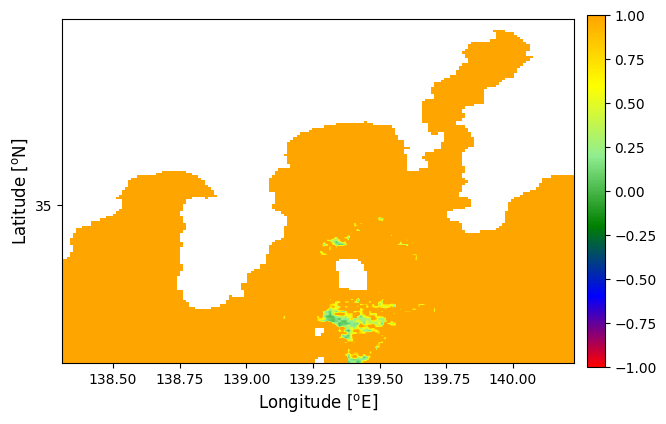

In [42]:
# Plot the results
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plot, colors
from matplotlib.colors import LinearSegmentedColormap

p_values = p_values  * 10
print(p_values)
# Create a Basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=lat[lat_inds[0]], urcrnrlat=lat[lat_inds[-1]],
            llcrnrlon=lon[lon_inds[0]], urcrnrlon=lon[lon_inds[-1]])

# Create a grid of coordinates
lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
rgb_colors = ["red","blue","green","lightgreen", "yellow", "orange"]


fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
ax.imshow(p_values, cmap='gray', vmin=-2, vmax=2, extent=extent)
# Create a colormap object
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

# ims = ax.imshow(trend_results,vmin=cmin, vmax=cmax,  extent=extent)
# ims = ax.imshow(p_values,  vmin=-1, vmax=1,   extent=extent)
ims = ax.imshow(p_values,vmin=-1, vmax=1, cmap=custom_colormap, extent=extent)

# # Figure labels
ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=20)
# cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")

# ticks = [ims.get_clim()[0],0, ims.get_clim()[1]] # This gets the color limit range
# cbar.set_ticks(ticks)
# cbar.set_ticklabels([f'{ticks[0]:.2f}', f'{ticks[1]:.2f}', f'{ticks[2]:.2f}']) # Format as desired

# Small Sagami Bay
lat_min, lat_max = 35.124, 35.34
lon_min, lon_max = 139.115, 139.68
plt.show()
# plt.savefig(f'yearly/sst/average_sst_{month:02d}.png', dpi=300)


[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-7.05003906 -7.62393981 -7.37215057 ... -2.70662511 -2.80874915
  -2.90342641]
 [-7.4905234  -7.7662631  -7.5389609  ... -2.3370023  -2.36149875
  -2.52990624]
 [-7.80919441 -8.09929135 -7.79595727 ... -2.24802156 -2.59654027
  -2.26508975]]
[[          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 [          nan           nan           nan ...           nan
            nan           nan]
 ...
 [-846.00468756 -914.87277697 -884.65806876 ... -324.79501278
  -337.0498976  -348.41116905]
 [-898.86280803 -931.95157142 -904.67530836 ... -280.44027652
  -283.37984952 -303.58874851]
 [-937.10332977 -971.91496219 -935.514

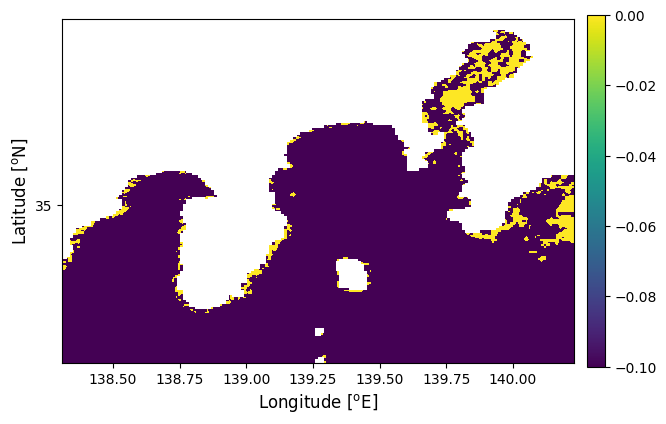

In [39]:

print(sen_slopes)
sen_slopes = sen_slopes *12* 10
print(sen_slopes)

# mask nan value to 0
# sen_slopes = sen_slopes * 12*10
# print(sen_slopes.min(), sen_slopes.max())

fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
# ax.imshow(sen_slopes, cmap='gray', vmin=0, vmax=1, extent=extent)
# Create a colormap object
# custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

# ims = ax.imshow(trend_results,vmin=cmin, vmax=cmax,  extent=extent)
ims = ax.imshow(sen_slopes,  vmin=-0.1, vmax=0, extent=extent)
# ims = ax.imshow(sen_slopes,vmin=0, vmax=1,  cmap=custom_colormap, extent=extent)

# # Figure labels
ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))
# ax.set_title(time[0].strftime('%b %Y'))

# # Colourbar
cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=20)


# Small Sagami Bay
lat_min, lat_max = 35.124, 35.34
lon_min, lon_max = 139.115, 139.68
plt.show()
# plt.savefig(f'yearly/sst/average_sst_{month:02d}.png', dpi=300)
